In [17]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Load a custom CSV file
data_files = {"train": "../../data/train_data.csv", "valid":"../../data/val_data.csv","test": "../../data/test_data.csv"}
dataset = load_dataset("csv", data_files=data_files)

# Inspect the first few samples
print(dataset["train"][0])
# Example: Mapping string labels to integers
label_mapping = {
    'notcb': 0,
    'gender': 1,
    'ethnicity': 2,
    'religion': 3,
    'age' : 4,
    'other': 5
}
dataset = dataset.map(lambda x: {"label": label_mapping[x["label"]]})

# Verify the mapping
print(dataset)

{'text': '[USER]: FUCK OBAMA, dumb ass nigger hahahaha you mad [HASHTAG] [HASHTAG]', 'label': 'ethnicity'}
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32638
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 8160
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7200
    })
})


In [18]:
tokenizer = AutoTokenizer.from_pretrained("../../models/distilroberta_finetuned_roc_auc")
model = AutoModelForSequenceClassification.from_pretrained("../../models/distilroberta_finetuned_roc_auc")

In [19]:

def tokenize_function(examples): #padding false becase of data collator later
    return tokenizer(examples["text"], padding=False, truncation=True, max_length=200)

# Apply the tokenizer to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Inspect tokenized samples
print(tokenized_datasets["train"][0])

Map: 100%|██████████| 7200/7200 [00:00<00:00, 28762.39 examples/s]


{'text': '[USER]: FUCK OBAMA, dumb ass nigger hahahaha you mad [HASHTAG] [HASHTAG]', 'label': 2, 'input_ids': [0, 10975, 47955, 42645, 46997, 28214, 19455, 6, 16881, 8446, 295, 41956, 2489, 298, 895, 11695, 47, 7758, 646, 725, 2336, 14469, 3450, 742, 646, 725, 2336, 14469, 3450, 742, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Predictions for accuracy/F1
    predictions = np.argmax(logits, axis=-1)

    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro"
    )
    acc = accuracy_score(labels, predictions)

    try:
        roc_auc = roc_auc_score(
            labels,
            probs,
            multi_class="ovr",
            average="macro"
        )
    except ValueError:
        roc_auc = float("nan")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }


In [22]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)

# Evaluate
results = trainer.evaluate()
print(results)

C:\Users\SEBASTIAN\PycharmProjects\MachinePaper\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\SEBASTIAN\PycharmProjects\MachinePaper\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.3611125648021698, 'eval_model_preparation_time': 0.0012, 'eval_accuracy': 0.8568055555555556, 'eval_precision': 0.8566984673985941, 'eval_recall': 0.8568055555555555, 'eval_f1': 0.8552140718814246, 'eval_roc_auc': 0.9768673842592593, 'eval_runtime': 125.0261, 'eval_samples_per_second': 57.588, 'eval_steps_per_second': 7.198}


C:\Users\SEBASTIAN\PycharmProjects\MachinePaper\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\SEBASTIAN\PycharmProjects\MachinePaper\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


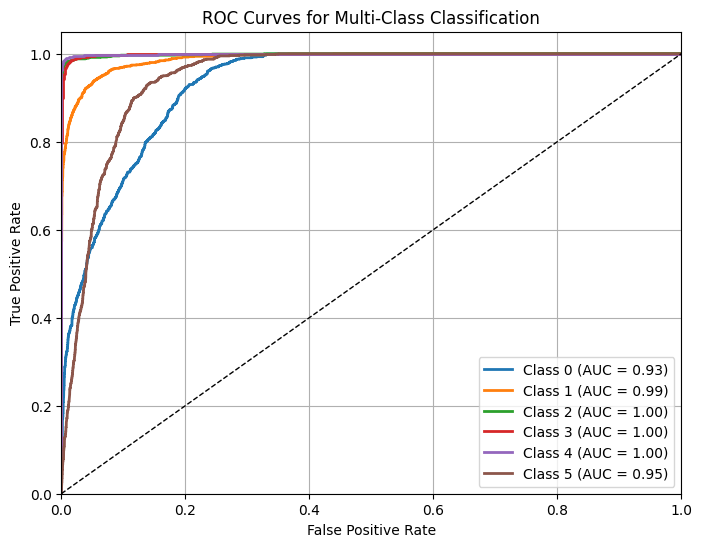

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predictions from the trainer
predictions = trainer.predict(tokenized_datasets["test"])
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to probabilities
probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)

# Binarize labels for multi-class ROC (One-vs-Rest)
n_classes = probs.shape[1]
y_bin = label_binarize(labels, classes=list(range(n_classes)))


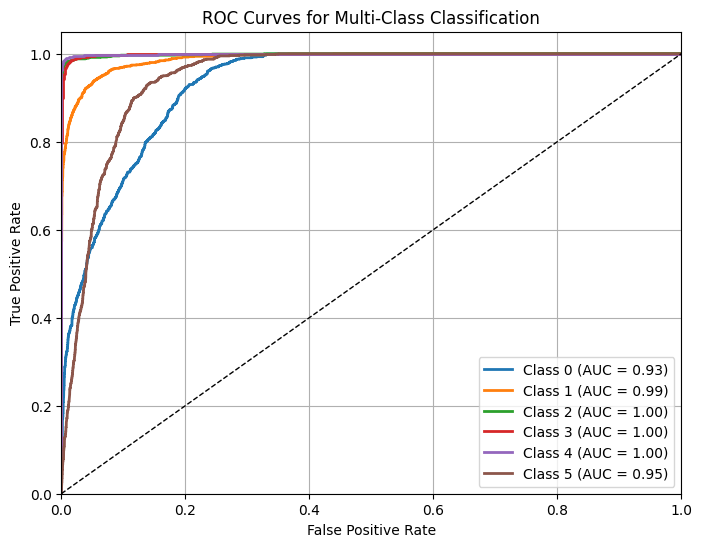

In [25]:
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Add random baseline
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curves.png")